In [1]:
!pip install langchain langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.2/138.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.8 MB/s eta 0:00:00


In [2]:
!pip install langchain-community --upgrade
!pip install langchain --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.1 MB/s eta 0:00:00


In [3]:
from langgraph.graph import StateGraph
from langchain.chat_models import ChatOpenAI

In [4]:
import os

openai_api_key = os.environ.get("OPENAI_API_KEY")
if not openai_api_key:
    raise ValueError("The environment variable OPENAI_API_KEY is not set. Please make sure to set it.")
llm = ChatOpenAI(api_key=openai_api_key, model="gpt-4o-mini")

<ipython-input-4-6dd41bacf947>:6: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(api_key=openai_api_key, model="gpt-4o-mini")


In [121]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Dict

# Define the state object that tracks the workflow
class InvoiceState(TypedDict):
    invoice_id: str
    po_number: str
    is_paid: bool
    payment_method: str
    payment_date: str
    po_type: str
    exception_status: str
    action_taken: str
    transmission_status: str

# Initialize the StateGraph
builder = StateGraph(InvoiceState)

# Define nodes for each step in the workflow

In [122]:
# Define the Imagenow Check Node
import pandas as pd
def imagenow_check(state: InvoiceState):
    print("\n=== Imagenow Check ===")

    # Load the Imagenow dataset
    imagenow_file_path = "/content/image_now_modified.xlsx"  # Replace with actual file path
    imagenow_df = pd.read_excel(imagenow_file_path)

    # Lookup the payment status for the given invoice number
    invoice_row = imagenow_df[imagenow_df["Invoice Number"] == state["invoice_id"]]

    if not invoice_row.empty:
        # Extract payment status
        state['is_paid'] = invoice_row.iloc[0]["Status"] == "Paid"
        print(f"Invoice {state['invoice_id']} payment status: {'Paid' if state['is_paid'] else 'Not Paid'}")
    else:
        # Default to not paid if the invoice is not found
        state['is_paid'] = False
        print(f"Invoice {state['invoice_id']} not found in Imagenow dataset. Marked as Not Paid.")

    return state



In [62]:
state = {
    "invoice_id": "INV-0010",
    "po_number": None,
    "is_paid": None,
    "po_length": None,
    "payment_method": None,
    "payment_date": None,
    "exception_status": None,
    "transmission_status": None
}

# Execute the node
imagenow_check(state)

# Output the updated state
print("\nUpdated State:", state)



=== Imagenow Check ===
Invoice INV-0010 payment status: Paid

Updated State: {'invoice_id': 'INV-0010', 'po_number': None, 'is_paid': True, 'po_length': None, 'payment_method': None, 'payment_date': None, 'exception_status': None, 'transmission_status': None}


In [123]:
# Define the Lawson Payment Check Node
def lawson_payment_check(state: InvoiceState):
    print("\n=== Lawson Payment Check ===")

    # Load the Lawson dataset
    lawson_file_path = "/content/lawson_modified.xlsx"  # Replace with actual file path
    lawson_df = pd.read_excel(lawson_file_path)

    # Lookup payment details for the given invoice ID
    invoice_row = lawson_df[lawson_df["Invoice ID"] == state["invoice_id"]]

    if not invoice_row.empty:
        # Extract payment details and exception status
        state['payment_method'] = invoice_row.iloc[0]["Payment Method"]
        state['payment_date'] = invoice_row.iloc[0]["Payment Date"]
        state['exception_status'] = invoice_row.iloc[0]["Exception Status"]

        # Print details for debugging
        print(f"Payment Method: {state['payment_method']}")
        print(f"Payment Date: {state['payment_date']}")
        print(f"Exception Status: {state['exception_status']}")
    else:
        # Default to unknown if the invoice ID is not found
        state['payment_method'] = None
        state['payment_date'] = None
        state['exception_status'] = None
        print(f"Invoice {state['invoice_id']} not found in Lawson dataset.")

    return state


In [64]:
state = {
    "invoice_id": "INV-0002",  # Change to test other invoice numbers
    "po_number": None,
    "is_paid": None,
    "po_length": None,
    "payment_method": None,
    "payment_date": None,
    "exception_status": None,
    "transmission_status": None
}

# Execute the node
lawson_payment_check(state)

# Output the updated state
print("\nUpdated State:", state)



=== Lawson Payment Check ===
Payment Method: Check
Payment Date: 2019-05-01 00:00:00
Exception Status: AP90

Updated State: {'invoice_id': 'INV-0002', 'po_number': None, 'is_paid': None, 'po_length': None, 'payment_method': 'Check', 'payment_date': Timestamp('2019-05-01 00:00:00'), 'exception_status': 'AP90', 'transmission_status': None}


In [124]:
def po_type_check(state: InvoiceState):
    print("Checking PO type (11-digit or 10-digit)...")
    if len(state['po_number']) == 11:
        state['po_type'] = "11-digit"
    elif len(state['po_number']) == 10:
        state['po_type'] = "10-digit"
    else:
        state['po_type'] = "Unknown"
    print(f"PO type determined: {state['po_type']}")
    return state


In [66]:
state = {
    "po_number": "12345678901",  # Change to test other PO numbers
    "po_type": None,
}

# Execute the node
po_type_check(state)

# Output the updated state
print("\nUpdated State:", state)


Checking PO type (11-digit or 10-digit)...
PO type determined: 11-digit

Updated State: {'po_number': '12345678901', 'po_type': '11-digit'}


In [125]:
def email_response_node(state: InvoiceState):
    print("\n=== Email Response Node ===")

    if state['is_paid']:  # Case: Invoice is paid
        print("Drafting email to vendor using LLM for a paid invoice...")

        # Handle missing payment method or date
        payment_method = state['payment_method'] or "Unavailable"
        payment_date = state['payment_date'] or "Unavailable"

        # LLM prompt for email drafting
        prompt = (
            f"Draft a professional email to inform the vendor that the payment for invoice {state['invoice_id']} "
            f"has been processed. Include the payment method ({payment_method}) and payment date ({payment_date})."
        )

        # Use LLM to generate the email content
        state['email_draft'] = llm.invoke(prompt).content
        print(f"Email Draft: {state['email_draft']}")

    elif not state['is_paid'] and state['payment_method'] and state['payment_date']:  # Case: Not paid, but details available
        print("Drafting email to vendor using LLM for pending payment with available details...")

        # Handle missing payment method or date
        payment_method = state['payment_method']
        payment_date = state['payment_date']

        # LLM prompt for email drafting
        prompt = (
            f"Draft a professional email to inform the vendor about the payment details for invoice {state['invoice_id']}. "
            f"Although the payment is pending, the system shows the following details: "
            f"Payment method: {payment_method}, Payment date: {payment_date}. "
            f"Request further confirmation if necessary."
        )

        # Use LLM to generate the email content
        state['email_draft'] = llm.invoke(prompt).content
        print(f"Email Draft: {state['email_draft']}")
    else:
        print("Invoice is not paid and no payment details are available. No email drafted.")

    return state



In [126]:
# Define the Email Response Node
def exception_response(state: InvoiceState):
    print("\n=== Exception Response Node ===")

    exception_emails = {
        "MA126": "finance_team@example.com",
        "MA54": "accounting_team@example.com",
        "P020": "compliance_team@example.com",
        "AP90": "vendor_relations@example.com"
    }

    if state['exception_status'] in exception_emails:
        recipient = exception_emails[state['exception_status']]
        print(f"Drafting email to {recipient} based on exception status: {state['exception_status']}")

        # Draft the email using LLM
        prompt = (
            f"Draft a professional email to {recipient} explaining the issue with invoice {state['po_number']}. "
            f"The exception status is {state['exception_status']}. Provide clear details about the issue and "
            f"request their assistance in resolving it."
        )
        state['email_draft_exception'] = llm.invoke(prompt).content
        print(f"Email Draft to {recipient}: {state['email_draft_exception']}")
    else:
        print(f"No email recipient found for exception status: {state['exception_status']}.")

    return state

In [127]:
def ivalua_check(state: InvoiceState):
    print("\n=== Ivalua Check ===")

    # Load the Ivalua dataset
    ivalua_file_path = "/content/ivalua_dataset.xlsx"  # Replace with the actual file path
    ivalua_df = pd.read_excel(ivalua_file_path)

    # Lookup the transmission and exception status for the given invoice
    invoice_row = ivalua_df[ivalua_df["Invoice Number"] == state["invoice_id"]]

    if not invoice_row.empty:
        # Extract transmission status and exception status
        state['transmission_status'] = invoice_row.iloc[0]["Transmission Status"]
        state['exception_status'] = invoice_row.iloc[0]["Exception status"]

        # Print details for debugging
        print(f"Transmission Status: {state['transmission_status']}")
        if pd.notna(state['exception_status']):
            print(f"Exception Status: {state['exception_status']}")
        else:
            print("No exception status found.")
    else:
        # Default values if invoice not found
        state['transmission_status'] = "Unknown"
        state['exception_status'] = None
        print(f"Invoice {state['invoice_id']} not found in Ivalua dataset.")

    return state


In [70]:
state = {
    "invoice_id": "INV-0003",  # Change to test other invoice numbers
    "po_number": None,
    "transmission_status": None,
    "exception_status": None
}

# Execute the Ivalua check node
ivalua_check(state)

# Output the updated state
print("\nUpdated State:", state)



=== Ivalua Check ===
Transmission Status: Not Transmitted
Exception Status: MA126

Updated State: {'invoice_id': 'INV-0003', 'po_number': None, 'transmission_status': 'Not Transmitted', 'exception_status': 'MA126'}


In [128]:
def update_notes(state: InvoiceState):
    print("\n=== Update Notes ===")
    # Simulate updating notes in Imagenow/Ivalua
    state['action_taken'] += " | Notes updated in Imagenow/Ivalua"
    print(state['action_taken'])
    return state

In [129]:
def check_payment_status(state: InvoiceState):
    print("\n=== Conditional Check: Payment Status ===")
    if state['is_paid']:
        return "Paid"
    else:
        return "NotPaid"

In [130]:
def check_po_length(state:InvoiceState):
  print("\n=== Conditional Check: PO Length ===")
  if state['po_type'] == "11-digit":
    return "11 Digit PO"
  else:
    return "10 Digit PO"

In [131]:
def ivalua_status_check(state: InvoiceState):
    print("\n=== Conditional Check: Ivalua Exception Handling ===")
    if state['transmission_status'] == "Transmitted":
        return "Transmitted"
    else:
        return "Not Transmitted"

In [132]:
#def check_exception_status(state: InvoiceState):
   # print("\n=== Conditional Check: Exception Status ===")
   # if state['exception_status'] == "AP90":
     #   print("Routing to 'email_response_node.")
     #   return "email_response_node"
    #else:
      # print("Routing to 'exception_response' node.")
       # return "exception_response"
def check_exception_status(state: InvoiceState):
    print("\n=== Conditional Check: Exception Status ===")

    # Check for AP90 or missing exception status (NaN)
    if state['exception_status'] == "AP90" or pd.isna(state['exception_status']):
        print("Routing to 'email_response_node'.")
        return "AP90/NAN"
    else:
        print("Routing to 'exception_response' node.")
        return "MA126/MA54/PO20"


In [133]:
# Add nodes to the graph
builder.add_node("imagenow_check", imagenow_check)
builder.add_node("lawson_payment_check", lawson_payment_check)
builder.add_node("email_response_node", email_response_node)
builder.add_node("po_type_check", po_type_check)
builder.add_node("ivalua_check", ivalua_check)
builder.add_node("update_notes", update_notes)
builder.add_node("exception_response", exception_response)




In [134]:
# Add conditional edges
builder.add_conditional_edges("imagenow_check", check_payment_status, {
    "Paid": "lawson_payment_check",
    "NotPaid": "po_type_check",

})

builder.add_conditional_edges("po_type_check", check_po_length, {
    "11 Digit PO": "ivalua_check",
    "10 Digit PO": "lawson_payment_check",
})



builder.add_conditional_edges(
    "lawson_payment_check",
    check_exception_status,
    {
        "AP90/NAN": "email_response_node",
        "MA126/MA54/PO20": "exception_response"
    }
)
builder.add_conditional_edges("ivalua_check", ivalua_status_check, {
    "Transmitted": "lawson_payment_check",
    "Not Transmitted": "exception_response",
})

# Add normal edges


builder.add_edge("email_response_node", "update_notes")

builder.add_edge("exception_response", "update_notes")

builder.add_edge("exception_response", "update_notes")



In [135]:
# Set the entry point
builder.set_entry_point("imagenow_check")

# Compile the graph
graph = builder.compile()

In [28]:
!apt-get install graphviz graphviz-dev # Install Graphviz using apt
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 49 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://a

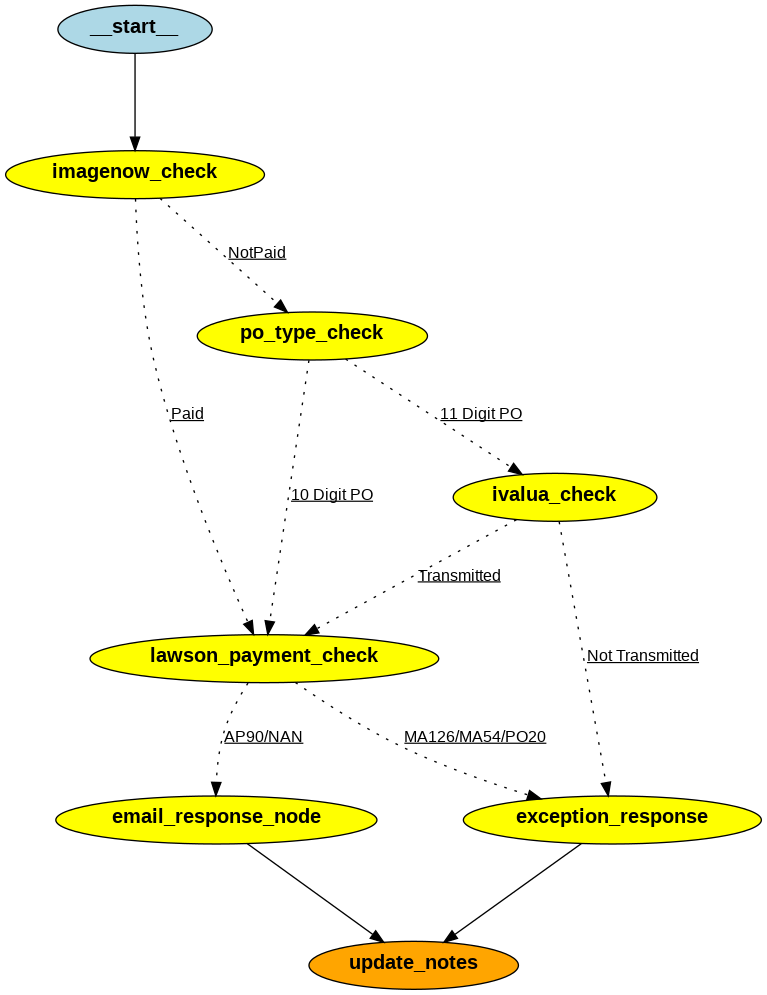

In [136]:
from IPython.display import Image

# Assuming `graph.get_graph()` provides a graph object and `.draw_png()` generates a PNG image
# Visualize the graph in a Jupyter notebook
Image(graph.get_graph().draw_png())

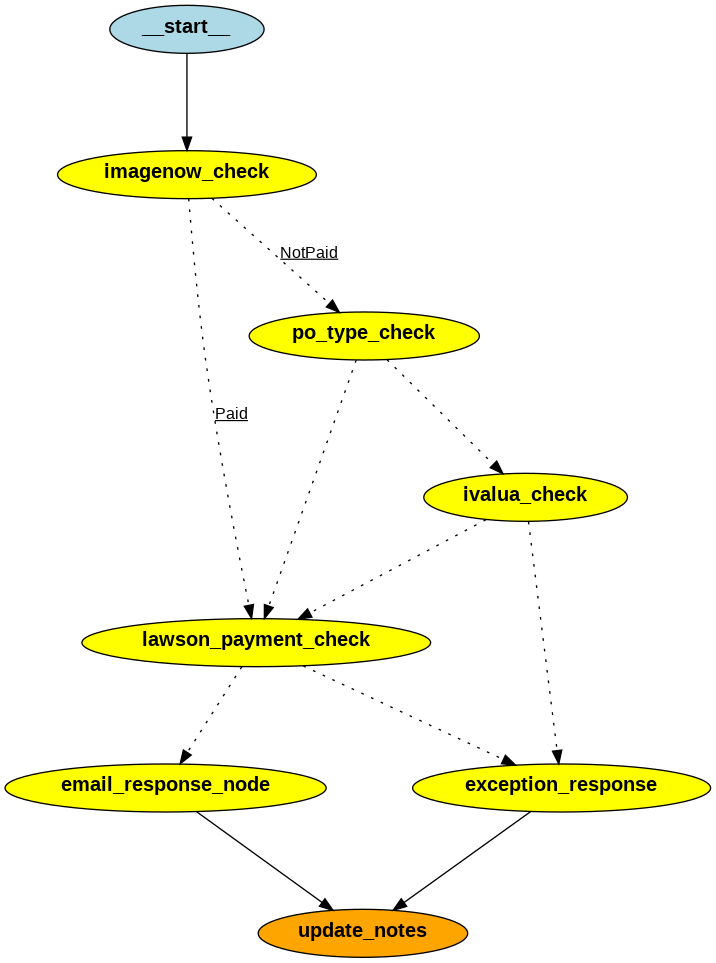

In [79]:
from IPython.display import Image

# Assuming `graph.get_graph()` provides a graph object and `.draw_png()` generates a PNG image
# Visualize the graph in a Jupyter notebook
Image(graph.get_graph().draw_png())

In [118]:
###Case 1 :(invoice is Paid)
 # Execute the workflow
state = InvoiceState(
    invoice_id="INV-0001",
    po_number="47687632524",
    is_paid="",
    payment_method="",
    po_type="",
    payment_date="",
    exception_status="",
    transmission_status="",
    action_taken=""
)

print("\n=== Starting Workflow Execution ===")
# Use the invoke method to execute the graph with the initial state
graph.invoke(state)



=== Starting Workflow Execution ===

=== Imagenow Check ===
Invoice INV-0001 payment status: Paid

=== Conditional Check: Payment Status ===

=== Lawson Payment Check ===
Payment Method: check
Payment Date: 2020-01-12 00:00:00
Exception Status: nan

=== Conditional Check: Exception Status ===
Routing to 'email_response_node'.

=== Email Response Node ===
Drafting email to vendor using LLM for a paid invoice...
Email Draft: Subject: Payment Confirmation for Invoice INV-0001

Dear [Vendor's Name],

I hope this message finds you well.

I am writing to inform you that the payment for Invoice INV-0001 has been successfully processed. The payment was made via check on January 12, 2020.

If you have any questions or require further details, please do not hesitate to reach out.

Thank you for your continued partnership.

Best regards,

[Your Name]  
[Your Position]  
[Your Company]  
[Your Phone Number]  
[Your Email Address]  

=== Update Notes ===
 | Notes updated in Imagenow/Ivalua


{'invoice_id': 'INV-0001',
 'po_number': '47687632524',
 'is_paid': True,
 'payment_method': 'check',
 'payment_date': Timestamp('2020-01-12 00:00:00'),
 'po_type': '',
 'exception_status': nan,
 'action_taken': ' | Notes updated in Imagenow/Ivalua',
 'transmission_status': ''}

In [82]:
###Case 2 :(Not paid,11 digit ,not transmitted)
 # Execute the workflow
state = InvoiceState(
    invoice_id="INV-0003",
    po_number="77649657916",  # Example 11-digit PO
    is_paid="",
    payment_method="",
    po_type="",
    payment_date="",
    exception_status="",
    transmission_status="",
    action_taken=""
)

print("\n=== Starting Workflow Execution ===")
# Use the invoke method to execute the graph with the initial state
graph.invoke(state)


=== Starting Workflow Execution ===

=== Imagenow Check ===
Invoice INV-0003 payment status: Not Paid

=== Conditional Check: Payment Status ===
Checking PO type (11-digit or 10-digit)...
PO type determined: 11-digit

=== Conditional Check: PO Length ===

=== Ivalua Check ===
Transmission Status: Not Transmitted
Exception Status: MA126

=== Conditional Check: Ivalua Exception Handling ===

=== Exception Response Node ===
Drafting email to finance_team@example.com based on exception status: MA126
Email Draft to finance_team@example.com: Subject: Assistance Required for Invoice 77649657916 - Exception Status MA126

Dear Finance Team,

I hope this message finds you well.

I am writing to bring to your attention an issue regarding invoice number 77649657916, which is currently showing an exception status of MA126. This status indicates that there is a discrepancy that needs to be addressed in order to proceed with processing the invoice.

Upon reviewing the invoice, it appears that [brief

{'invoice_id': 'INV-0003',
 'po_number': '77649657916',
 'is_paid': False,
 'payment_method': '',
 'payment_date': '',
 'po_type': '11-digit',
 'exception_status': 'MA126',
 'action_taken': ' | Notes updated in Imagenow/Ivalua',
 'transmission_status': 'Not Transmitted'}

In [120]:
###Case 3 :(Not paid,11 digit PO,transmitted,MA54)
 # Execute the workflow
state = InvoiceState(
    invoice_id="INV-0012",
    po_number="36182291467",  # Example 11-digit PO
    is_paid="",
    payment_method="",
    po_type="",
    payment_date="",
    exception_status="",
    transmission_status="",
    action_taken=""
)

print("\n=== Starting Workflow Execution ===")
# Use the invoke method to execute the graph with the initial state
graph.invoke(state)


=== Starting Workflow Execution ===

=== Imagenow Check ===
Invoice INV-0012 payment status: Not Paid

=== Conditional Check: Payment Status ===
Checking PO type (11-digit or 10-digit)...
PO type determined: 11-digit

=== Conditional Check: PO Length ===

=== Ivalua Check ===
Transmission Status: Transmitted
No exception status found.

=== Conditional Check: Ivalua Exception Handling ===

=== Lawson Payment Check ===
Payment Method: nan
Payment Date: NaT
Exception Status: MA54

=== Conditional Check: Exception Status ===
Routing to 'exception_response' node.

=== Exception Response Node ===
Drafting email to accounting_team@example.com based on exception status: MA54
Email Draft to accounting_team@example.com: Subject: Assistance Required for Invoice 36182291467 - Exception Status MA54

Dear Accounting Team,

I hope this message finds you well.

I am writing to bring to your attention an issue with invoice number 36182291467, which currently has an exception status of MA54. We have re

{'invoice_id': 'INV-0012',
 'po_number': '36182291467',
 'is_paid': False,
 'payment_method': nan,
 'payment_date': NaT,
 'po_type': '11-digit',
 'exception_status': 'MA54',
 'action_taken': ' | Notes updated in Imagenow/Ivalua',
 'transmission_status': 'Transmitted'}

In [119]:
###Case 4 :(Not paid,transmitted and realeased ,AP90)
 # Execute the workflow
state = InvoiceState(
    invoice_id="INV-0009",
    po_number="81092089028",  # Example 11-digit PO
    is_paid="",
    payment_method="",
    po_type="",
    payment_date="",
    exception_status="",
    transmission_status="",
    action_taken=""
)

print("\n=== Starting Workflow Execution ===")
# Use the invoke method to execute the graph with the initial state
graph.invoke(state)


=== Starting Workflow Execution ===

=== Imagenow Check ===
Invoice INV-0009 payment status: Not Paid

=== Conditional Check: Payment Status ===
Checking PO type (11-digit or 10-digit)...
PO type determined: 11-digit

=== Conditional Check: PO Length ===

=== Ivalua Check ===
Transmission Status: Transmitted
No exception status found.

=== Conditional Check: Ivalua Exception Handling ===

=== Lawson Payment Check ===
Payment Method: Debit Card
Payment Date: 2020-02-01 00:00:00
Exception Status: AP90

=== Conditional Check: Exception Status ===
Routing to 'email_response_node'.

=== Email Response Node ===
Drafting email to vendor using LLM for pending payment with available details...
Email Draft: Subject: Payment Details for Invoice INV-0009

Dear [Vendor's Name],

I hope this message finds you well.

I am writing to inform you about the payment details related to invoice INV-0009. Please note that while the payment is still pending, our system indicates the following details:

- **P

{'invoice_id': 'INV-0009',
 'po_number': '81092089028',
 'is_paid': False,
 'payment_method': 'Debit Card',
 'payment_date': Timestamp('2020-02-01 00:00:00'),
 'po_type': '11-digit',
 'exception_status': 'AP90',
 'action_taken': ' | Notes updated in Imagenow/Ivalua',
 'transmission_status': 'Transmitted'}

In [81]:
###Case 5 :(10 digit PO)
 # Execute the workflow
state = InvoiceState(
    invoice_id="INV-0004",
    po_number="2198219623",  # Example 11-digit PO
    is_paid="",
    payment_method="",
    po_type="",
    payment_date="",
    exception_status="",
    transmission_status="",
    action_taken=""
)

print("\n=== Starting Workflow Execution ===")
# Use the invoke method to execute the graph with the initial state
graph.invoke(state)


=== Starting Workflow Execution ===

=== Imagenow Check ===
Invoice INV-0004 payment status: Not Paid

=== Conditional Check: Payment Status ===
Checking PO type (11-digit or 10-digit)...
PO type determined: 10-digit

=== Conditional Check: PO Length ===

=== Lawson Payment Check ===
Payment Method: nan
Payment Date: NaT
Exception Status: MA126

=== Conditional Check: Exception Status ===
Routing to 'exception_response' node.

=== Exception Response Node ===
Drafting email to finance_team@example.com based on exception status: MA126
Email Draft to finance_team@example.com: Subject: Assistance Required with Invoice 2198219623 – Exception Status MA126

Dear Finance Team,

I hope this message finds you well.

I am writing to bring to your attention an issue we have encountered with invoice number 2198219623. Currently, this invoice is showing an exception status of MA126, which has prevented us from processing it further.

Upon reviewing the details, it appears that there may be a discre

{'invoice_id': 'INV-0004',
 'po_number': '2198219623',
 'is_paid': False,
 'payment_method': nan,
 'payment_date': NaT,
 'po_type': '10-digit',
 'exception_status': 'MA126',
 'action_taken': ' | Notes updated in Imagenow/Ivalua',
 'transmission_status': ''}